In [1]:
using Distributions, TimeIt, ProgressMeter, PyPlot, JLD
include("zz_structures.jl")
include("mbsampler.jl")

get_clustering (generic function with 1 method)

In [2]:
X = load("GZZ_data.jld", "X")
y = load("GZZ_data.jld", "y")
ξ_true = load("GZZ_data.jld", "xi_true");

d, Nobs = size(X)
mb_size = Int(round(Nobs/10))
σ02 = 1
prior = GDP_prior(d, σ02)

GDP_prior(50, 1.0, [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 1.0, 1.0, 1.0, 1.0, 1.0)

In [3]:
ξ_true[ξ_true .!= 0]

7-element Array{Float64,1}:
 -0.731787
 -6.2554  
  9.27311 
  6.42829 
  7.38964 
 -7.66661 
 -8.43724 

In [4]:
my_ll = ll_logistic(X,y);
my_model = model(my_ll, prior)
root = find_root(my_model, rand(d));

In [5]:
# Sub-Sampling without control variate and with weights
ϵ = 1e-2
weights = abs.(X) + ϵ
weights ./= sum(weights,2)
gs = [wumbsampler(Nobs, mb_size, weights[i,:]) for i in 1:d]
gs_list = mbsampler_list(d,gs);

In [6]:
A = eye(d)

opf = projopf(A, 1000, hyperparam_size(prior))
opt = maxa_opt(10^6)
outp = outputscheduler(opf,opt)
bb = linear_bound(my_model.ll, my_model.pr, gs_list, zz_state(opf))
update_bound(bb, my_ll, prior, gs_list, zz_state(opf));

In [7]:
adapt_speed = false
L = 1
my_zz_sampler = zz_sampler(0, gs_list, bb, L, adapt_speed)
hyper_sampler = block_gibbs_sampler(1.)
blocksampler = Array{msampler}(2)
blocksampler[1] = my_zz_sampler
blocksampler[2] = hyper_sampler;

In [8]:
start = time()
ZZ_block_sample(my_model::model, outp::outputscheduler, blocksampler::Array{msampler})
print( round((time()-start)/60, 2), " mins")

10% attempts in 0.28 mins 
20% attempts in 0.56 mins 
30% attempts in 0.83 mins 
40% attempts in 1.1 mins 
50% attempts in 1.39 mins 
60% attempts in 1.67 mins 
70% attempts in 1.95 mins 
80% attempts in 2.23 mins 
90% attempts in 2.52 mins 
100% attempts in 2.8 mins 
2.81 mins

In [9]:
size(outp.opf.xi_skeleton)

(50, 67658)

In [10]:
discard = 0
n_samples = 10^4
xi_samples = extract_samples(outp.opf.xi_skeleton[:,discard+1:end], 
                             outp.opf.bt_skeleton[:,discard+1:end], 
                             outp.opf.bt_skeleton[end]/n_samples,
                             "linear")[:,1:end-1];
hyp_samples = extract_samples(outp.opf.hyper_skeleton[:,discard+1:end], 
                              outp.opf.bt_skeleton[:,discard+1:end], 
                              outp.opf.bt_skeleton[end]/n_samples,
                              "constant")[:,1:end-1];

In [16]:
maxlag = 200
acfs_xi = zeros(d, maxlag)
acfs_hyp = zeros(size(hyp_samples,1), maxlag)

for i in 1:d 
    acfs_xi[i,:] = acf(xi_samples[i,:], maxlag)
end
for i in 1:size(hyp_samples,1)
    acfs_hyp[i,:] = acf(hyp_samples[i,:], maxlag)
end

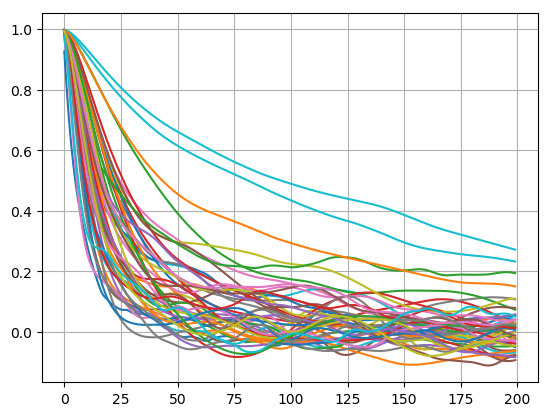

In [17]:
for i in 1:d 
    plot(acfs_xi[i,:])
end
grid(true)

In [14]:
cover = zeros(d)
ci = zeros(d,2)
for i in 1:d 
    ci[i,:] = percentile(xi_samples[i,:], [5, 95])
    cover[i] = (ci[i,1]<ξ_true[i])&(ξ_true[i]<ci[i,2])
end

In [15]:
100*mean(cover)

88.0